<a href="https://colab.research.google.com/github/Alexey1998-ml/cv/blob/master/Global_Wheat_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! pip install albumentations==0.4.6

     |████████████████████████████████| 122kB 5.5MB/s 
     |████████████████████████████████| 952kB 18.3MB/s 
  Created wheel for albumentations: filename=albumentations-0.4.6-cp36-none-any.whl size=65165 sha256=862842bc34ecd0a1e9a1fb9151cbb982d94678b7cede3c0f666e18d8694e4841
  Stored in directory: /root/.cache/pip/wheels/c7/f4/89/56d1bee5c421c36c1a951eeb4adcc32fbb82f5344c086efa14
Successfully built albumentations
  Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9
  Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


In [2]:
%cd drive/My\ Drive/Global\ Wheat\ Detection/
from metric import calculate_image_precision
%cd ../../../

/content/drive/My Drive/Global Wheat Detection
/content


In [3]:
import pandas as pd
import numpy as np
import cv2
import os
import re

from PIL import Image

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

import torch
import torchvision

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SequentialSampler

from matplotlib import pyplot as plt

import numba
import ast
from numba import jit
from typing import List, Union, Tuple

DIR_INPUT = 'drive/My Drive/Global Wheat Detection/'
DIR_TRAIN = f'{DIR_INPUT}/train'
DIR_TEST = f'{DIR_INPUT}/test'

In [4]:
train_df = pd.read_csv(f'{DIR_INPUT}/train.csv')
train_df.shape

(147793, 5)

In [5]:
def expand_bbox(x):
    r = np.array(re.findall("([0-9]+[.]?[0-9]*)", x))
    if len(r) == 0:
        r = [-1, -1, -1, -1]
    return r

train_df['x'] = -1
train_df['y'] = -1
train_df['w'] = -1
train_df['h'] = -1

train_df[['x', 'y', 'w', 'h']] = np.stack(train_df['bbox'].apply(lambda x: expand_bbox(x)))
train_df.drop(columns=['bbox'], inplace=True)
train_df['x'] = train_df['x'].astype(np.float)
train_df['y'] = train_df['y'].astype(np.float)
train_df['w'] = train_df['w'].astype(np.float)
train_df['h'] = train_df['h'].astype(np.float)

In [6]:
image_ids = train_df['image_id'].unique()
valid_ids = image_ids[-665:]
train_ids = image_ids[:-665]

In [7]:
valid_df = train_df[train_df['image_id'].isin(valid_ids)]
train_df = train_df[train_df['image_id'].isin(train_ids)]

In [8]:
class WheatDataset(Dataset):

    def __init__(self, dataframe, image_dir, transforms=None):
        super().__init__()

        self.image_ids = dataframe['image_id'].unique()
        self.df = dataframe
        self.image_dir = image_dir
        self.transforms = transforms

    def __getitem__(self, index: int):

        image_id = self.image_ids[index]
        records = self.df[self.df['image_id'] == image_id]

        image = cv2.imread(f'{self.image_dir}/{image_id}.jpg', cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0

        boxes = records[['x', 'y', 'w', 'h']].values
        boxes[:, 2] = boxes[:, 0] + boxes[:, 2]
        boxes[:, 3] = boxes[:, 1] + boxes[:, 3]
        
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        area = torch.as_tensor(area, dtype=torch.float32)

        # there is only one class
        labels = torch.ones((records.shape[0],), dtype=torch.int64)
        
        # suppose all instances are not crowd
        iscrowd = torch.zeros((records.shape[0],), dtype=torch.int64)
        
        target = {}
        target['boxes'] = boxes
        target['labels'] = labels
        # target['masks'] = None
        target['image_id'] = torch.tensor([index])
        target['area'] = area
        target['iscrowd'] = iscrowd

        if self.transforms:
            sample = {
                'image': image,
                'bboxes': target['boxes'],
                'labels': labels
            }
            sample = self.transforms(**sample)
            image = sample['image']
            
            target['boxes'] = torch.stack(tuple(map(torch.tensor, zip(*sample['bboxes'])))).permute(1, 0)

        return image, target, image_id

    def __len__(self) -> int:
        return self.image_ids.shape[0]

In [9]:
def get_train_transform():
    return A.Compose([
        A.Flip(0.5),
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

def get_valid_transform():
    return A.Compose([
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

In [21]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


In [ ]:
num_classes = 2  # 1 class (wheat) + background

# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

In [11]:
class Averager:
    def __init__(self):
        self.current_total = 0.0
        self.iterations = 0.0

    def send(self, value):
        self.current_total += value
        self.iterations += 1

    @property
    def value(self):
        if self.iterations == 0:
            return 0
        else:
            return 1.0 * self.current_total / self.iterations

    def reset(self):
        self.current_total = 0.0
        self.iterations = 0.0

In [10]:
def collate_fn(batch):
    return tuple(zip(*batch))

train_dataset = WheatDataset(train_df, DIR_TRAIN, get_train_transform())
valid_dataset = WheatDataset(valid_df, DIR_TRAIN, get_valid_transform())



# split the dataset in train and test set
indices = torch.randperm(len(train_dataset)).tolist()

train_data_loader = DataLoader(
    train_dataset,
    batch_size=8,
    shuffle=False,
    num_workers=4,
    collate_fn=collate_fn
)

valid_data_loader = DataLoader(
    valid_dataset,
    batch_size=2,
    shuffle=False,
    num_workers=4,
    collate_fn=collate_fn
)

In [13]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [14]:
images, targets, image_ids = next(iter(train_data_loader))
images = list(image.to(device) for image in images)
targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

In [15]:
boxes = targets[1]['boxes'].cpu().numpy().astype(np.int32)
sample = images[1].permute(1,2,0).cpu().numpy()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


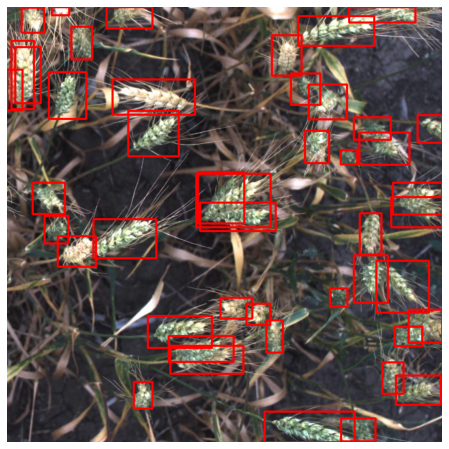

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))

for box in boxes:
    cv2.rectangle(sample,
                  (box[0], box[1]),
                  (box[2], box[3]),
                  (220, 0, 0), 3)
    
ax.set_axis_off()
ax.imshow(sample)

In [17]:
model.to(device)
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
# lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)
lr_scheduler = None

num_epochs = 1

In [18]:
loss_hist = Averager()
itr = 1
model.double()
for epoch in range(num_epochs):
    loss_hist.reset()
    
    for images, targets, image_ids in train_data_loader:
        
        images = list(image.double().to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)

        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()

        loss_hist.send(loss_value)

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        if itr % 10 == 0:
            print(f"Iteration #{itr} loss: {loss_value}")

        itr += 1
    
    # update the learning rate
    if lr_scheduler is not None:
        lr_scheduler.step()

    print(f"Epoch #{epoch} loss: {loss_hist.value}")   

/usr/local/lib/python3.6/dist-packages/torchvision/ops/boxes.py:101: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:766.)
  keep = keep.nonzero().squeeze(1)


Iteration #10 loss: 1.454881892622101
Iteration #20 loss: 1.1222854699726774
Iteration #30 loss: 1.5143576031811525
Iteration #40 loss: 1.1263642276827488
Iteration #50 loss: 0.9991187405702393
Iteration #60 loss: 0.9206293385166029
Iteration #70 loss: 0.9442892728399052
Iteration #80 loss: 0.9724213757819424
Iteration #90 loss: 1.0895606895566472
Iteration #100 loss: 1.0110419061936198
Iteration #110 loss: 1.014268029882709
Iteration #120 loss: 0.9120864942317995
Iteration #130 loss: 0.9283478979723974
Iteration #140 loss: 1.0298504248060156
Iteration #150 loss: 0.9343842493993973
Iteration #160 loss: 0.8262007144254538
Iteration #170 loss: 0.603034569390201
Iteration #180 loss: 2.2847812484733505
Iteration #190 loss: 0.996083626943336
Iteration #200 loss: 0.7730080933403425
Iteration #210 loss: 0.7472742488239743
Iteration #220 loss: 0.690081828570868
Iteration #230 loss: 0.8061027022241322
Iteration #240 loss: 0.7884755192581963
Iteration #250 loss: 0.7908572397077019
Iteration #260

In [32]:
images, targets, image_ids = next(iter(valid_data_loader))

In [33]:
images = list(img.double().to(device) for img in images)
targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

In [34]:
boxes_gt = targets[0]['boxes'].cpu().numpy().astype(np.int32)
sample = images[0].permute(1,2,0).cpu().numpy()

In [35]:
model.eval()
cpu_device = torch.device("cpu")

outputs = model(images)
outputs = [{k: v.to(cpu_device) for k, v in t.items()} for t in outputs]
boxes_preds = outputs[0]['boxes']

RuntimeError: ignored

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


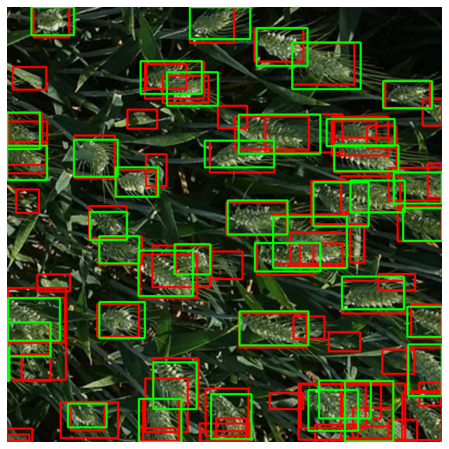

In [161]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))
# green = gt, red - preds
for box in boxes_preds:
    cv2.rectangle(sample,
                  (box[0], box[1]),
                  (box[2], box[3]),
                  (220, 0, 0), 3)
for box in boxes_gt:
    cv2.rectangle(sample,
                (box[0], box[1]),
                (box[2], box[3]),
                (0, 255, 0), 3)
    
ax.set_axis_off()
ax.imshow(sample)

In [26]:
torch.save(model.state_dict(), f'{DIR_INPUT}/fasterrcnn_resnet50_fpn.pth')

# Eval

In [11]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=False, pretrained_backbone=False)

In [12]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

num_classes = 2  # 1 class (wheat) + background

# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
# Load the trained weights
model.load_state_dict(torch.load(f'{DIR_INPUT}/fasterrcnn_resnet50_fpn.pth'))
model.to(device)
model.eval()
model.double()

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256)
          (relu): ReLU(inplace=True)
          (downsample)

In [13]:
validation_image_precisions = []
iou_thresholds = [x for x in np.arange(0.5, 0.76, 0.05)]

In [17]:
images, targets, image_ids = next(iter(valid_data_loader))
images = list(img.double().to(device) for img in images)
outputs = model(images)
outputs = [{k: v.to(device) for k, v in t.items()} for t in outputs]
targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
for idx in range(len(images)):
  boxes_gt = targets[idx]['boxes'].cpu().numpy().astype(np.int32)
  scores = outputs[idx]['scores'].detach().cpu().numpy().astype(float)
  scores = np.array([score for score in scores if score >= 0.5])
  scores_sorted_idx = np.argsort(scores)[::-1]
  scores_sorted = scores[scores_sorted_idx]
  boxes_preds = outputs[idx]['boxes'].detach().cpu().numpy().astype(np.int32)
  boxes_pred_sort = boxes_preds[scores_sorted_idx]
  sample = images[idx].permute(1,2,0).cpu().numpy()
  image_precision = calculate_image_precision(boxes_pred_sort,
                          boxes_gt,
                          thresholds=iou_thresholds,
                          form='coco')
  validation_image_precisions.append(image_precision)
print(f'Mean image precisions: {np.mean(validation_image_precisions)}')


Mean image precisions: 0.9194108680332138


In [15]:
validation_image_precisions

[0.8695652173913043, 0.9692565186751232]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


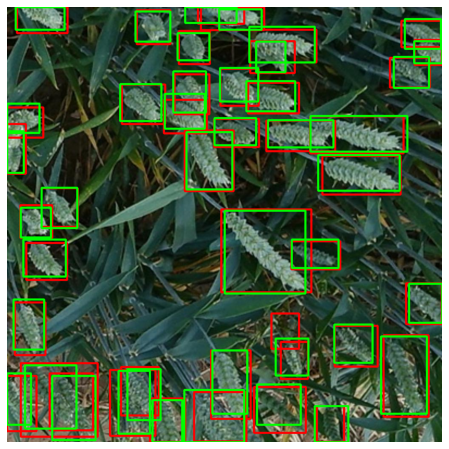

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))
# green = gt, red - preds
for box in boxes_pred_sort:
    cv2.rectangle(sample,
                  (box[0], box[1]),
                  (box[2], box[3]),
                  (220, 0, 0), 3)
for box in boxes_gt:
    cv2.rectangle(sample,
                (box[0], box[1]),
                (box[2], box[3]),
                (0, 255, 0), 3)
    
ax.set_axis_off()
ax.imshow(sample)

In [126]:
calculate_image_precision(boxes_pred_sort,
                          boxes_gt,
                          thresholds=iou_thresholds,
                          form='coco')


0.8695652173913043